In [3]:
import numpy as np
import pandas as pd

In [4]:
# -*- coding: utf-8 -*-

# ----------------------------------------------------------------------------------------------------------------------------------
# A program for computing the CLB distance and the Jaccard index for different solutions and comparing them.
# Acceleration with numba.
# Three directories with phi files are given as input.
#
# Command line parameters:
# pyKLBDist.py -d1 csv1t -d2 csv2t -d3 csv3t -o cmp -ct 0 -jd 100
# d1: directory with first solution
# d1: directory with second solution
# d1: directory with third solution
# jd: Jakkard depth
# ct: compare thresold
# o: output directory name. If not specified, the output files are generated in the current directory.
# 
# Results are written to the output files in CSV format.
#
# Date: 21/03/2022. Vladimir Filippov.
#
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

import sys
import os
import re
import csv
import math
import struct
import argparse
import binascii
from numba import njit, typed, types
from numba.typed import Dict
import numpy as np
#from gensim.models import keyedvectors as kd
               
               


In [5]:
def createParser():
    parser = argparse.ArgumentParser()
    parser.add_argument('-d1', default='?', help='Dir with solution 1')
    parser.add_argument('-d2', default='?', help='Dir with solution 2')
    parser.add_argument('-d3', default='?', help='Dir with solution 3')
    parser.add_argument('-o', default='.', help='Output directory name')
    parser.add_argument('-jd', default=100, help='Jakkard depth', type=int)
    parser.add_argument('-ct', default=0, help='Compare thresold', type=int)
    return parser

# Function for converting a word to crc32
def word2crc32(s_word):
    return (binascii.crc32(s_word.encode('cp1251'), 0xFFFFFFFF) ^ 0xFFFFFFFF) & 0xFFFFFFFF



In [6]:
@njit
def calcKLB(cluster_sol_col1, cluster_sol_col2, fgsData_dictionary, fgsData_cluster1, fgsData_cluster2):
    n, m = cluster_sol_col1, cluster_sol_col2
    KLB_matrix = [[0.0 for j in range(m)] for i in range(n)]
    max_prob = -10000000000;
    print("  Computing KLB... ")
    # cycle on the topics of the second cluster solution
    percomp_prev = 0
    for s_t2 in range(cluster_sol_col2):
        # loop on the topics of the first cluster solution
        for s_t1 in range(cluster_sol_col1):
            # dictionary cycle
            KLB_topic = 0
            for wrd in fgsData_dictionary:
                # search by crc32 code in the first solution
                prob1 = fgsData_cluster1[wrd][s_t1]
                # search by crc32 code in the second solution
                prob2 = fgsData_cluster2[wrd][s_t2]
                if prob1<0.0001: prob1 = 0.0001
                if prob2<0.0001: prob2 = 0.0001
                pp1 = prob1*math.log(prob1/prob2)
                pp2 = prob2*math.log(prob2/prob1)
                KLB_topic = KLB_topic + (pp1+pp2)/2
                if max_prob<KLB_topic: max_prob = KLB_topic
                KLB_matrix[s_t1][s_t2] = KLB_topic
            percomp = int(((s_t1+1)*(s_t2+1))*100/(cluster_sol_col1*cluster_sol_col2))
            #if percomp>percomp_prev:
            #    percomp_prev = percomp
            #    print("  Progress = ", percomp, "%")#, end='\r')
    
    return KLB_matrix, max_prob

# Function that reads KLB and Jakkard for two input files
def KLBandJakkard(inp_file1, inp_file2, jakdepth):
    #fgsData_dictionary = {}
    fgsData_dictionary = Dict.empty(key_type=types.int64, value_type=types.unicode_type,)
    # read input file 1
    print("  Loading the first file... ", end='\r')
    ugof1 = open(inp_file1, 'r', newline='', encoding='cp1251')
    csv_data1 = csv.reader(ugof1, delimiter=';', quoting=csv.QUOTE_ALL, doublequote=True, quotechar='"')
    
    fgsData_cluster1 = Dict.empty(key_type=types.int64, value_type=types.float64[:],)
    cluster_sol_col1 = 0
    curline = 0
    for row in csv_data1:
        curline+=1
        if curline==1: 
            tailcol = 1
            if row[len(row)-1]=="": tailcol = 2
            cluster_sol_col1 = len(row)-tailcol # определяем число тем
            continue
        currw = row[0]
        currw32 = word2crc32(row[0])
        fgsData_dictionary[currw32] = currw
        probs = []
        for prob in row[1:]: 
            s = str(prob).replace(",", ".")
            if s != "": probs.append(float(s))
        fgsData_cluster1[currw32] = np.asarray(probs)
    print("  Loading the first file...  OK")
    ugof1.close()

    # read input file 2
    print("  Loading the second file... ", end='\r')
    ugof2 = open(inp_file2, 'r', newline='', encoding='cp1251')
    csv_data2 = csv.reader(ugof2, delimiter=';', quoting=csv.QUOTE_ALL, doublequote=True, quotechar='"')

    #fgsData_cluster2 = {}
    fgsData_cluster2 = Dict.empty(key_type=types.int64, value_type=types.float64[:],)
    cluster_sol_col2 = 0
    curline = 0
    for row in csv_data2:
        curline+=1
        if curline==1: 
            tailcol = 1
            if row[len(row)-1]=="": tailcol = 2
            cluster_sol_col2 = len(row)-tailcol # определяем число тем
            continue
        currw = row[0]
        currw32 = word2crc32(row[0])
        fgsData_dictionary[currw32] = currw
        probs = []
        for prob in row[1:]: 
            s = str(prob).replace(",", ".")
            if s != "": probs.append(float(s))
        fgsData_cluster2[currw32] = np.asarray(probs)
    print("  Loading the second file...  OK")
    ugof2.close()
    
    KLB_matrix, max_prob = calcKLB(cluster_sol_col1, cluster_sol_col2, fgsData_dictionary, fgsData_cluster1, fgsData_cluster2)

    print("  Renormalize and computing Jakkard index... ", end='\r')
    # перенормировка
    topic_to_topic = []
    for s_t1 in range(cluster_sol_col1):
        curent_topic = 0
        curent_topic_max = 0
        for s_t2 in range(cluster_sol_col2):
            KLB_topic = KLB_matrix[s_t1][s_t2]
            if KLB_topic==0: KLB_topic = max_prob
            KLB_topic = (1-KLB_topic/max_prob)*100
            KLB_matrix[s_t1][s_t2] = KLB_topic
            if KLB_topic>curent_topic_max:
                curent_topic_max = KLB_topic
                curent_topic = s_t2
        t2t = [s_t1, curent_topic_max, curent_topic, 0]
        topic_to_topic.append(t2t)

    wordcnt = min(1000, len(fgsData_cluster1), len(fgsData_cluster2))
    outdata = []
    for t2t in topic_to_topic:
        topic1 = t2t[0]
        topic2 = t2t[2]
        # of probabilities from the topic of the first solution
        wordprob1 = {}
        for clus1 in fgsData_cluster1:
            wordprob1[clus1] = fgsData_cluster1[clus1][topic1]
        wordprob1_sorted = sorted(wordprob1.items(), key=lambda x: x[1])
        # of probabilities from the subject of the second solution
        wordprob2 = {}
        for clus2 in fgsData_cluster2:
            wordprob2[clus2] = fgsData_cluster2[clus2][topic2]
        wordprob2_sorted = sorted(wordprob2.items(), key=lambda x: x[1])
        outdata_item = []
        for k in range(wordcnt):
            wrd1,prob1 = wordprob1_sorted[-(k+1)]
            wrd2,prob2 = wordprob2_sorted[-(k+1)]
            outdata_item.append([wrd1,wrd2])
        outdata.append(outdata_item)
    # jaccard
    jw = min(jakdepth, wordcnt);
    for k in range(len(topic_to_topic)):
        c = 0
        for c1 in range(jw):
            for c2 in range(jw):
                if outdata[k][c1][0] == outdata[k][c2][1]:
                    c += 1
                    break;
        jm = c*1.0/(jw+jw-c)
        topic_to_topic[k][3] = jm
    print("  Renormalize and computing Jakkard index... OK")
    #
    return topic_to_topic

In [7]:
# here we set up 3 folder, which contains 3 topics model runs
dir1 = 'E:/word_embeding_TM/Stability/test/run1/'
dir2 = 'E:/word_embeding_TM/Stability/test/run2/'
dir3 = 'E:/word_embeding_TM/Stability/test/run3/'

# folder were number of simuilar were stored
out_dirname = 'E:/word_embeding_TM/Stability/test/output'

# paraemeters of model
jakdepth = 100
sthresold = 90

In [8]:
# we will read three directories and create ordered 
# lists of three files with the same number of topics
# these lists will be fed to the routines and we will get a list of stable topics
# we'll create a dictionary that will contain as a key the number of topics 
# and as a value file name
file_topics1 = dict()

# read the list of files from directory 1

results1 = dir1

# arrange a loop through these files
for i in os.listdir(results1):
    #print('file name: ', results1+i)
    #print()
    f = results1+i
    phidf = pd.read_csv(f,  sep=';', encoding='utf8')
    #print('Dataset size', phidf.shape)
    num_rows, num_feature = phidf.shape
    numtopic = num_feature -1
    #print('Topic number: ', numtopic)
    file_topics1[numtopic] = f

#print('----------------------------------')
    
file_topics2 = dict()

# read the list of files from directory 2

results1 = dir2

# arrange a loop through these files
for i in os.listdir(results1):
    #print('file name: ', results1+i)
    f = results1+i
    phidf = pd.read_csv(f,  sep=';', encoding='utf8')
    #print('Dataset size', phidf.shape)
    num_rows, num_feature = phidf.shape
    numtopic = num_feature -1
    #print('Topic number: ', numtopic)
    file_topics2[numtopic] = f
    
file_topics3 = dict()

# arrange a loop through these files
results1 = dir3
# arrange a loop through these files
for i in os.listdir(results1):
    #print('file name: ', results1+i)
    f = results1+i
    phidf = pd.read_csv(f,  sep=';', encoding='utf8')
    #print('Dataset size', phidf.shape)
    num_rows, num_feature = phidf.shape
    numtopic = num_feature -1
    #print('Topic number: ', numtopic)
    file_topics3[numtopic] = f
    
    
print('lists of 3 files are created')

lists of 3 files are created


In [172]:
#file_topics2

In [9]:
import time

t1=time.time()

# Main routine
if __name__ == '__main__':

    print('Calculating the KLB and Jakkard index for solutions and compare its')

    for my_topics in range(2, 50, 1):
        print(my_topics)
        inp_file1 = file_topics1[my_topics]
        inp_file2 = file_topics2[my_topics] 
        inp_file3 = file_topics3[my_topics]
        
        print('Topic number: ', my_topics)
        sol1 = KLBandJakkard(inp_file1, inp_file2, jakdepth)
        sol2 = KLBandJakkard(inp_file1, inp_file3, jakdepth)
            
        # comparison of two solutions 
        outcsvfn = out_dirname+"/"+"cmp_"+str(len(sol1))+".csv"            
        ugof = open(outcsvfn, 'w', newline='')#, encoding='utf_8_sig')
        writer = csv.writer(ugof, delimiter=';')
        for item1 in sol1:
            simil = 0
            for item2 in sol2:
                if item1[1]>=sthresold and item1[0] == item2[0]:
                    if item2[1]>=sthresold: simil = item2[2]+1 # topic number starts with 1, so add 1
                    break
            if simil>0:
                writer.writerow([item1[3], item1[0]+1, item1[2]+1, simil])
        ugof.close()
        
    #
    print("Calculations completed")
    
t2=time.time()

print('total time: ', t2-t1)

Calculating the KLB and Jakkard index for solutions and compare its
2
Topic number:  2
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
3
Topic number:  3
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
4
Topic number:  4
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
5
Topic number:  5
  Loading the first file...  OK
  Loading the second file.

  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
31
Topic number:  31
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
32
Topic number:  32
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
33
Topic number:  33
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Renormalize and computing Jakkard index... OK
  Loading the first file...  OK
  Loading the second file...  OK
  Computing KLB... 
  Reno

In [11]:
# read the list of files and create a list of stable topics
results1 = 'E:/word_embeding_TM/Stability/test/output/'

stable_topics = []
number_topics = []

# arrange a loop through these files
for i in os.listdir(results1):

    f = results1+i
    phidf = pd.read_csv(f,  sep=';', encoding='utf8')

    num_rows, num_feature = phidf.shape

    numtopic =(re.findall('\d+', i ))
    number_topics.append(int(numtopic[0]))
    stable_topics.append(num_rows)

    #print('Topic number: ', numtopic)
    #file_topics1[numtopic] = f

print('----------------------------------')

----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

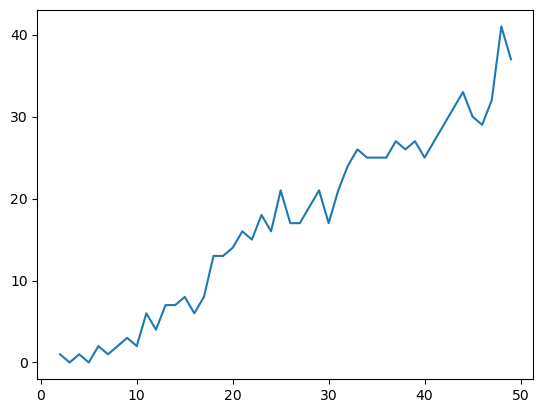

In [12]:
import seaborn as sns
sns.lineplot(number_topics,stable_topics , x='topic number', y='number of stable topics')